In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

In [3]:
folder_path = "../trained_models/"
model_names = ["ravdess_mvae_data_8k.save",
               "ravdess_mvae_data_12k_altloss.save",
               "ravdess_mvae_data_8k_altloss_01.save",
               "ravdess_mvae_data_8k_altloss_02.save",
               "ravdess_mvae_data_8k_altloss_03.save",
               "ravdess_mvae_data_8k_altloss_04.save",
               "ravdess_mvae_data_8k_altloss_05.save",
               "ravdess_mvae_data_8k_altloss_06.save"
              ]

ravdess_mvae_data_8k.save  :kld=  495.63398922424676
{'cat_dim': 8, 'latent_space_dim': 8192, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'face': 5.0, 'emotion': 0.5}, 'expert_type': 'moe', 'use_cuda': True}
ravdess_mvae_data_12k_altloss.save  :kld=  916.226168579407
{'cat_dim': 8, 'latent_space_dim': 12000, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'face': 5.0, 'emotion': 1.0}, 'expert_type': 'moe', 'use_cuda': True}
ravdess_mvae_data_8k_altloss_01.save  :kld=  743.9877872679301
{'cat_dim': 8, 'latent_space_dim': 8192, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'face': 1.0, 'emotion': 1.0}, 'expert_type': 'moe', 'use_cuda': True}
ravdess_mvae_data_8k_altloss_02.save  :kld=  1031.0619918380505
{'cat_dim': 8, 'latent_space_dim': 8192, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'face': 5.0, 'emotion': 1.0}, 'expert_type': 'moe', 'use_cuda': True}
ravdess_mvae_data_8k_altloss_03.save  :kld=  1724.9129319032531
{'cat_dim': 8, 'latent_

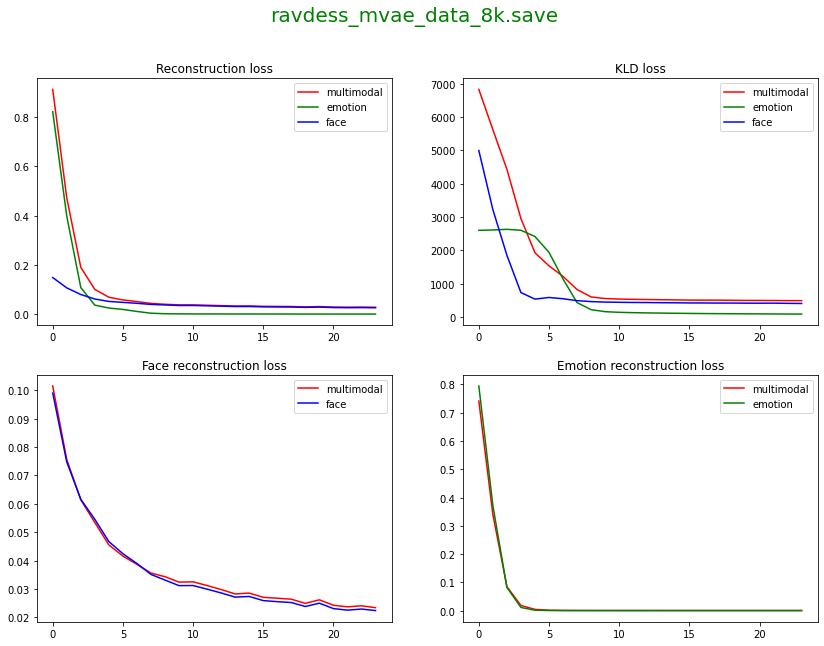

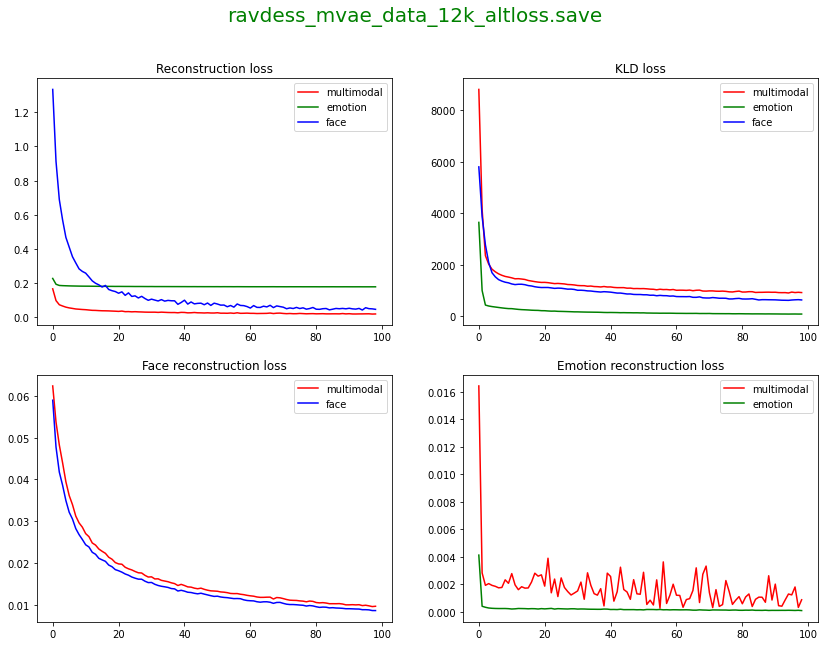

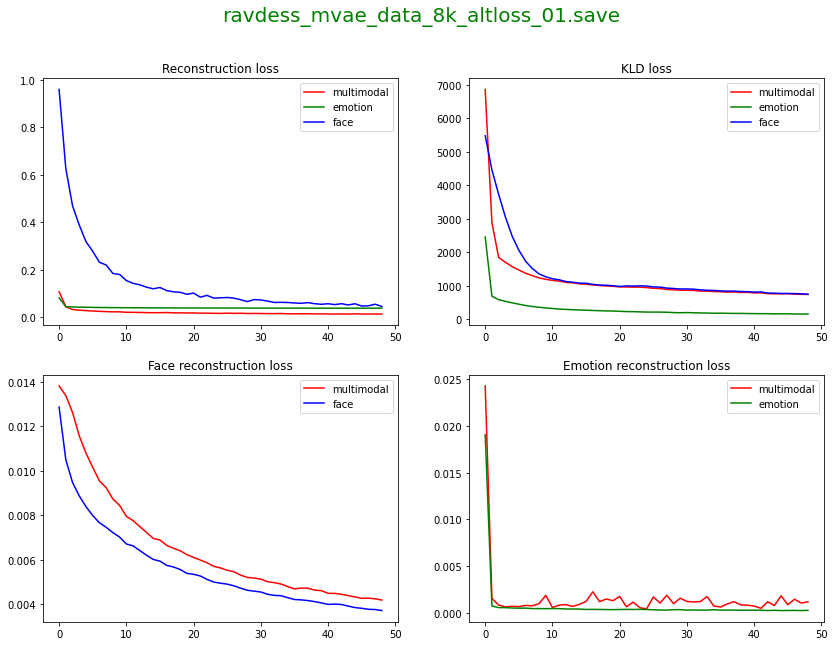

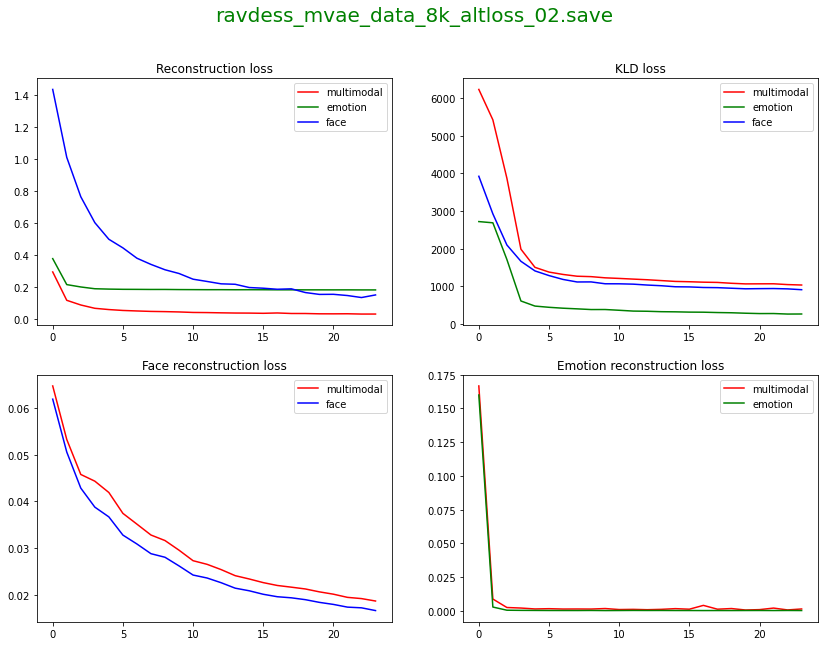

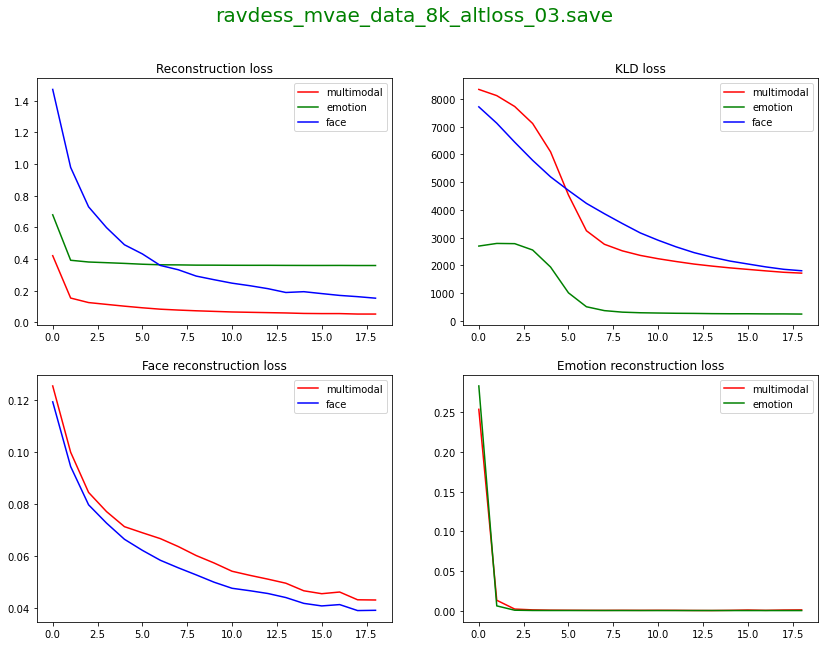

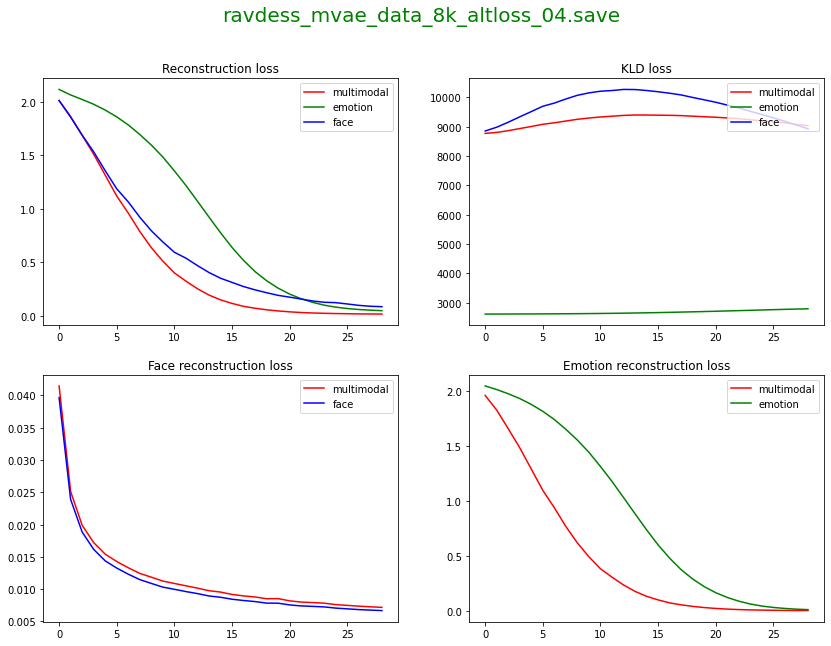

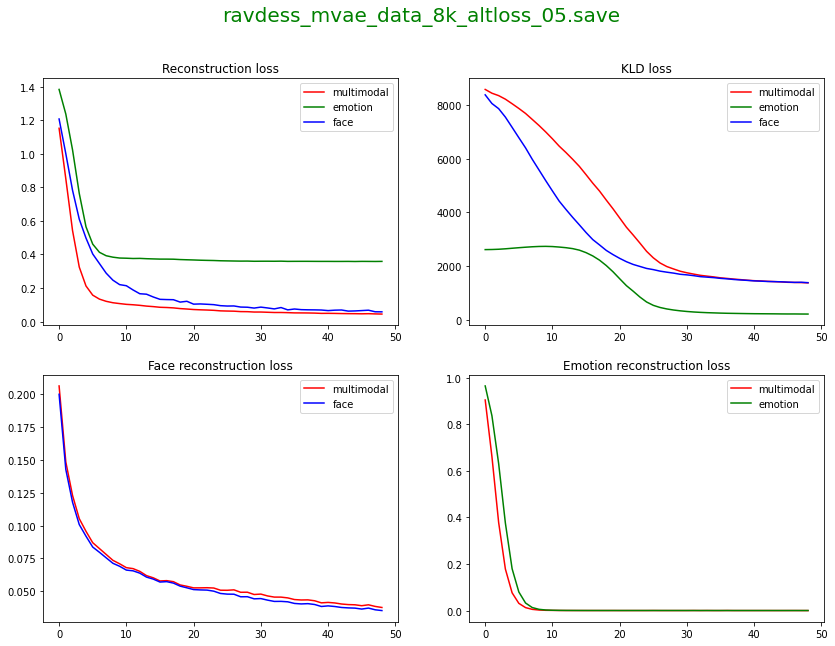

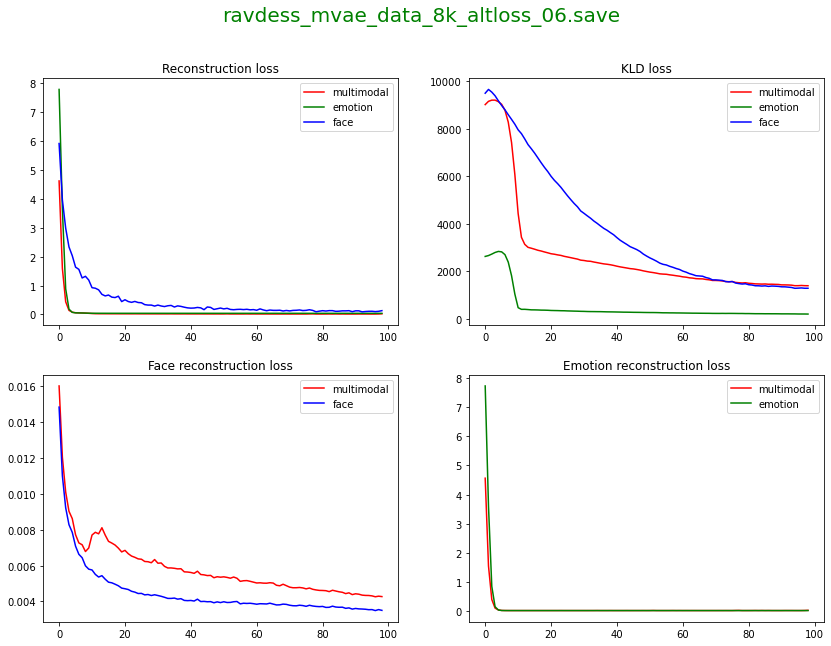

In [5]:
for model_name in model_names:
    loaded_data = torch.load(folder_path + model_name)
    losses = loaded_data['training_loss']
    model_args = loaded_data['model_args']
    print(model_name,' :kld= ', losses['multimodal_loss'].kld_loss[-1])
    print(model_args)
    
    U.print_losses(losses , model_name, 1)

In [ ]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 80
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

In [ ]:
'''for model_name in model_names:
    loaded_data = torch.load(folder_path + model_name)
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    model.eval()
    
    U.test_batch(model, testset_loader)'''

In [ ]:
import matplotlib.pyplot as plt
Rd.emocat

In [ ]:
emotion = 2
print(Rd.emocat[emotion])

emotion = torch.tensor([emotion]).to('cuda')
plt.figure(figsize = (5,5))
r_image, _, _, _ = model(faces=None, emotions=emotion)
_, r_emotion, _, _ = model(faces=r_image, emotions=None)
r_image = torch.clamp(r_image, min=0, max=1)
r_image = np.array(r_image.cpu().detach().numpy()[0]).transpose((1, 2, 0))
plt.imshow(r_image)
print((Rd.emocat[torch.argmax(r_emotion.cpu()).item()]))